In [2]:
import sys
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import logsumexp
from scipy.stats import gaussian_kde
sys.path.append('../vbpi-torch/rooted')
sys.path.append('../')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import torch
from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI
from VIPR import VIPR

In [3]:
sns.set_style("whitegrid")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_palette("muted")    # Options: deep, muted, bright, pastel, dark, colorblind

In [4]:
import pandas as pd

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# Plot by Dataset

In [5]:
data_set = "DS14"
pop_size = 5.0 # exponential parameter for constant pop size prior

# initialize models
models = {"reinforce": {},
          "reparam": {},
          "VIMCO": {},
          "VBPI": {}}

data_file = '../../dat/'+data_set+'/'+data_set+'.pickle'

# models
models = ["reparam","reinforce","VIMCO","BEAST","VBPI"]

# Beast file
BEAST_pref = '../../dat/'+data_set+'/'+data_set+'_MLL_'
BEAST_burnin = 250000

# VPBI files
VBPI_dir = '../../results/'+data_set+'/'

# Requirements for VBPI

In [6]:
# load the sequence data and estimate the subsplit support
data, taxa = loadData('../../dat/'+data_set+'/'+data_set+'.nexus', 'nexus')
mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../../dat/'+data_set+'/'+data_set+'_fixed_pop_support_short_run', 'nexus', burnin=250)
rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
#del mcmc_support_trees_dict, mcmc_support_trees_wts

In [7]:
# load the ground truth
#mcmc_sampled_trees_dict, mcmc_sampled_trees_wts, _ = tree_summary('../dat/DS1/DS1_fixed_pop_golden_run.trees', 'nexus', burnin=25001)
emp_tree_freq = None#{mcmc_sampled_trees_dict[tree_id]: tree_wts for tree_id, tree_wts in sorted(mcmc_sampled_trees_wts.items(), key=lambda x:x[1], reverse=True)}
sample_info = [0.0 for taxon in taxa]
#del mcmc_sampled_trees_dict, mcmc_sampled_trees_wts

In [8]:
# set up the model
VBPI_models = {}
VBPI_models["10"] = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

VBPI_models["20"] = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

# Load in the relevant files

2
3
4
4
mcmc_vimco_10_0.003_psp_fixed_pop_fixed_rate_1_2025-02-13_01-21-17.pt
3
3
5
4
mcmc_vimco_20_0.003_psp_fixed_pop_fixed_rate_4_2025-02-23_06-46-54.pt


(-8000.0, -7800.0)

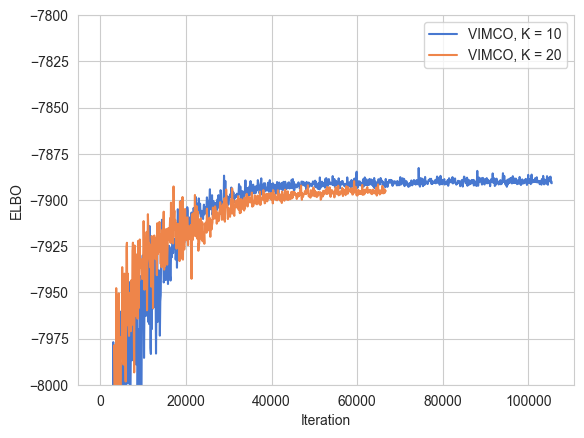

In [12]:
# VBPI
VBPI_runtimes = {}
VBPI_lbs = {}
VBPI_iters = {}

legend = []

for bs in ["10","20"]:
    
    VBPI_runtimes[bs] = None
    VBPI_lbs[bs] = None
    VBPI_iters[bs] = None
    lb_star = -np.inf
    file_star = None
    
    for ss in ["0.003","0.001","0.0003","0.0001"]:
    #for ss in ["1e-05"]:
        VBPI_pref = "mcmc_vimco_%s_%s_psp_fixed_pop_fixed_rate_"%(bs,ss)
        files = [x for x in os.listdir(VBPI_dir) if x.startswith(VBPI_pref)]
        files = [x for x in files if x.endswith(".pt")]
        new_files = []

        for x in files:

            if "2025-02" in x:
                new_files.append(x)
        
        files = new_files
        print(len(files))
        
        for file in files:
        
            VBPI_runtimes0 = np.load(VBPI_dir+file.replace(".pt","_run_time.npy"))
            VBPI_lbs0 = np.load(VBPI_dir+file.replace(".pt","_test_lb.npy"))
            VBPI_iters0 = np.load(VBPI_dir+file.replace(".pt","_iters.npy"))

            if np.mean(VBPI_lbs0[-10:]) > lb_star:
                VBPI_runtimes[bs] = VBPI_runtimes0
                VBPI_lbs[bs] = VBPI_lbs0
                VBPI_iters[bs] = VBPI_iters0
                VBPI_models[bs].load_from(VBPI_dir+file)
                lb_star = np.mean(VBPI_lbs0[-10:])
                file_star = file
        
            
    print(file_star)
    plt.plot(VBPI_iters[bs],VBPI_lbs[bs])
    plt.xlabel("Iteration")
    legend.append("VIMCO, K = %s"%(bs))  

plt.ylabel("ELBO")
plt.legend(legend)
plt.ylim([-8000,-7800])

In [13]:
# BEAST
def load_beast(data_set,i,burnin):
    df = pd.read_csv('../../dat/'+data_set+'/'+data_set+'_fixed_pop_MLL_%d.log'%i, 
                     sep = '\t',skiprows=[0,1,2])
    df = df[df.state > burnin]
    return df

BEAST_data = pd.concat([load_beast(data_set,i,BEAST_burnin) for i in range(1,11)])
BEAST_MLLs = []

# extract MLL from beast log
for i in range(1,11):
    with open('../../dat/'+data_set+'/'+data_set+"_MLL_%d.txt"%i, "r") as text_file:
        line = text_file.readlines()[-4]
    ind = np.where([not x in "-1234567890." for x in line])[0][-2]
    BEAST_MLLs.append(float(line[(ind+1):-1]))

In [16]:
# my models
optims = {}
settings = {}
ELBO_star = -np.inf
fname_star = None
ELBO_min = np.inf
ELBO_max = -np.inf

for model in ["reinforce","reparam","VIMCO"]:
    
    optims[model] = None
    ELBO_star = -np.inf
    
    for ss in [0.03,0.01,0.003,0.001]:
    
        for rs in range(5):
            
            optim_dir = '../../results/'+data_set+'/'
            optim_pref = data_set+'_'+model+'_'+str(ss)+'_'+str(rs)
            files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
            
            files = [x for x in files if "2025_02" in x]

            if not files:
                print(optim_pref + " does not exist. Continuing...")
                continue
            
            fname = optim_dir + max(files)
    
            with open(fname, 'rb') as f:
                optim0 = pickle.load(f)
            
            if np.mean(optim0.multi_ELBO_ests[-10:]) > ELBO_star:
                optims[model] = optim0
                settings[model] = (ss,rs)
                ELBO_star = np.mean(optim0.multi_ELBO_ests[-10:])
                fname_star = fname
                
    print(fname_star)
    
    if max(optims[model].multi_ELBO_ests) > ELBO_max:
        ELBO_max = max(optims[model].multi_ELBO_ests)

    if min(optims[model].multi_ELBO_ests) < ELBO_min:
        ELBO_min = min(optims[model].multi_ELBO_ests)

DS14_reinforce_0.003_4 does not exist. Continuing...
../../results/DS14/DS14_reinforce_0.03_2_2025_02_13_06_27_16.pickle
DS14_reparam_0.03_1 does not exist. Continuing...
DS14_reparam_0.03_2 does not exist. Continuing...
DS14_reparam_0.03_4 does not exist. Continuing...
DS14_reparam_0.01_0 does not exist. Continuing...
DS14_reparam_0.01_1 does not exist. Continuing...
DS14_reparam_0.01_2 does not exist. Continuing...
DS14_reparam_0.01_3 does not exist. Continuing...
DS14_reparam_0.003_1 does not exist. Continuing...
DS14_reparam_0.003_3 does not exist. Continuing...
DS14_reparam_0.001_0 does not exist. Continuing...
DS14_reparam_0.001_1 does not exist. Continuing...
DS14_reparam_0.001_2 does not exist. Continuing...
DS14_reparam_0.001_3 does not exist. Continuing...
DS14_reparam_0.001_4 does not exist. Continuing...
../../results/DS14/DS14_reparam_0.03_0_2025_02_12_23_28_41.pickle
DS14_VIMCO_0.003_3 does not exist. Continuing...
DS14_VIMCO_0.001_3 does not exist. Continuing...
../../re

In [17]:
for model in optims:
    optims[model].epochs = [i*10 for i in range(len(optims[model].epochs))]

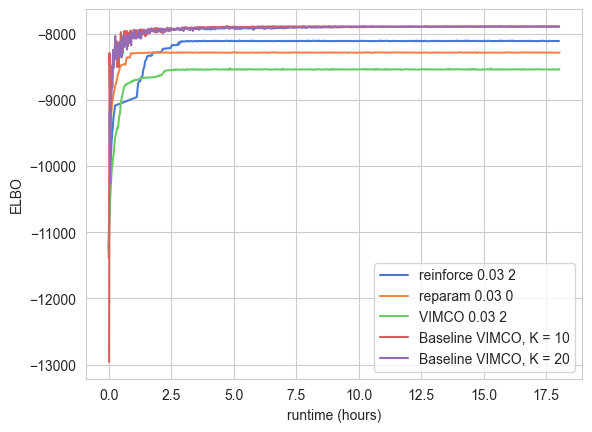

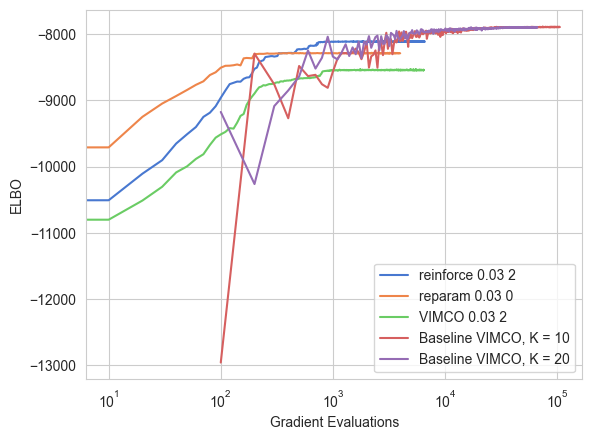

In [20]:
legend = []
for model in ["reinforce","reparam","VIMCO"]:
    plt.plot(np.cumsum(optims[model].run_times)/3600,optims[model].multi_ELBO_ests)
    legend.append(model+" "+str(settings[model][0])+" "+str(settings[model][1]))

for bs in ["10","20"]:
    ELBO_max = max(ELBO_max,max(VBPI_lbs[bs]))
    plt.plot(np.cumsum(VBPI_runtimes[bs])/3600,VBPI_lbs[bs])
    legend.append("Baseline VIMCO, K = %s"%(bs))  

plt.xlabel("runtime (hours)")
plt.ylabel("ELBO")
plt.legend(legend)
#plt.ylim([ELBO_min-10,ELBO_max+10])
plt.savefig('../../plt/'+data_set+'/'+data_set+'_ELBO_v_time.png')
#plt.ylim([ELBO_max-20,ELBO_max+10])
plt.savefig('../../plt/'+data_set+'/'+data_set+'_ELBO_v_time_zoom.png')
plt.show()

##############

legend = []
for model in ["reinforce","reparam","VIMCO"]:
    plt.plot(optims[model].epochs,optims[model].multi_ELBO_ests)
    legend.append(model+" "+str(settings[model][0])+" "+str(settings[model][1]))

for bs in ["10","20"]:
    plt.plot(VBPI_iters[bs],VBPI_lbs[bs])
    legend.append("Baseline VIMCO, K = %s"%(bs))  

plt.xlabel("Gradient Evaluations")
plt.ylabel("ELBO")
plt.legend(legend)

plt.xscale('log')
    
#plt.ylim([ELBO_min-10,ELBO_max+10])
plt.savefig('../../plt/'+data_set+'/'+data_set+'_ELBO_v_iter.png')
#plt.ylim([ELBO_max-20,ELBO_max+10])
plt.savefig('../../plt/'+data_set+'/'+data_set+'_ELBO_v_iter_zoom.png')
plt.show()

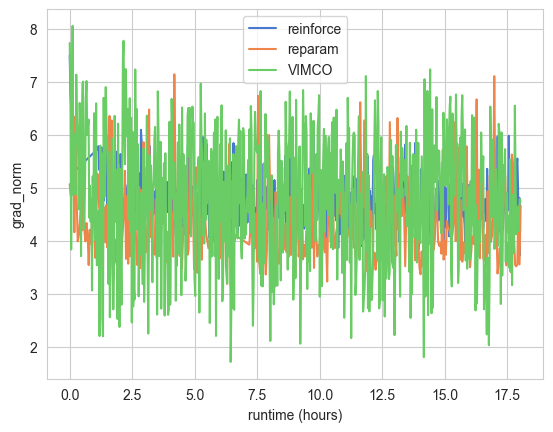

In [21]:
legend = []
    
for model in ["reinforce","reparam","VIMCO"]:
                
        plt.plot(np.cumsum(optims[model].run_times)/3600,np.log(optims[model].grad_norms))
        legend.append(model)

plt.xlabel("runtime (hours)")
plt.ylabel("grad_norm")
plt.legend(legend)
plt.savefig('../../plt/'+data_set+'/'+data_set+'_grad_norm_v_time.png')

# plot estimated ELBO over time

In [22]:
tree_lengths = {}
root_heights = {}
log_likes = {}
log_priors = {}
p_qs = {}

# Get data from BEAST

In [23]:
# get lengths from BEAST
tree_lengths["BEAST"] = BEAST_data.treeLength[BEAST_data.state > BEAST_burnin].to_numpy()
root_heights["BEAST"] = BEAST_data['treeModel.rootHeight'][BEAST_data.state > BEAST_burnin].to_numpy()
log_likes["BEAST"] = BEAST_data.likelihood[BEAST_data.state > BEAST_burnin].to_numpy()
log_priors["BEAST"] = BEAST_data.prior[BEAST_data.state > BEAST_burnin].to_numpy()

# Get data from VBPI

In [24]:
for bs in ["10","20"]:
    self = VBPI_models[bs]
    n_runs = 1000
    n_particles = 1

    root_heights["VBPI_%s"%bs] = []
    tree_lengths["VBPI_%s"%bs] = []
    log_priors["VBPI_%s"%bs] = []
    log_likes["VBPI_%s"%bs] = []
    p_qs["VBPI_%s"%bs] = []

    for i in range(n_runs):
        if i % int(n_runs/10) == 0:
            print(i/n_runs)
        with torch.no_grad():
            samp_trees = [self.tree_model.sample_tree() for particle in range(n_particles)]
            [namenum(tree, self.taxa) for tree in samp_trees]
            logq_tree = torch.stack([self.logq_tree(tree) for tree in samp_trees])

            samp_branch, logq_height, height, event_info = self.branch_model(samp_trees)
            log_clock_rate, logq_clock_rate = self.clock_model.sample(n_particles=n_particles)
            samp_branch = samp_branch.to(torch.float32) * log_clock_rate.exp()
            logll = torch.stack([self.phylo_model.loglikelihood(branch, tree) for branch, tree in zip(*[samp_branch, samp_trees])])

            self.tree_prior_model.update_batch(height, event_info)
            coalescent_param, logq_prior = self.tree_prior_model.sample_pop_size(n_particles=n_particles)
            logp_coalescent_prior, _ = self.tree_prior_model(coalescent_param, False)

            logp_clock_rate = self.clock_model(log_clock_rate)

            # get values
            root_heights["VBPI_%s"%bs].extend(list(height[:,0].numpy()))
            tree_lengths["VBPI_%s"%bs].extend(list(np.sum(samp_branch.numpy(),axis=1)))
            log_priors["VBPI_%s"%bs].extend(list(logp_coalescent_prior.numpy() + logp_clock_rate))
            log_likes["VBPI_%s"%bs].extend(list(logll.numpy()))
            p_qs["VBPI_%s"%bs].append((logll + logp_coalescent_prior + logp_clock_rate - logq_tree - logq_height - logq_prior - logq_clock_rate - math.log(n_particles)).item())

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


# Get data from my code

In [30]:
n_exp = 1000

for model in ["reinforce","reparam","VIMCO"]:
    with torch.no_grad():
        theta = optims[model].theta

        optims[model].var_dist = "LogNormal"

        root_heights[model] = []
        tree_lengths[model] = []
        log_priors[model] = []
        log_likes[model] = []
        p_qs[model] = []

        for i in range(n_exp):
            
            if i % int(n_exp/10) == 0:
                print(i/n_exp)

            Z = optims[model].sample_q()
            log_prior = optims[model].logprior(Z)
            log_ll = optims[model].loglikelihood(Z)
            log_q = optims[model].logvariational(Z)
            tree,branches = optims[model].scipy_linkage_to_ete3(Z)

            p_qs[model].append(log_prior.item() + log_ll.item() - log_q.item())
            log_likes[model].append(log_ll.item())
            log_priors[model].append(log_prior.item())
            root_heights[model].append(Z[-1,2].item())
            tree_lengths[model].append(sum([node.branch for node in tree.traverse() if node.branch]).item())

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [31]:
tree_lengths.keys()

dict_keys(['BEAST', 'VBPI_10', 'VBPI_20', 'reinforce', 'reparam', 'VIMCO'])

# Recreate Figure 9 from Zhang et al (2024)

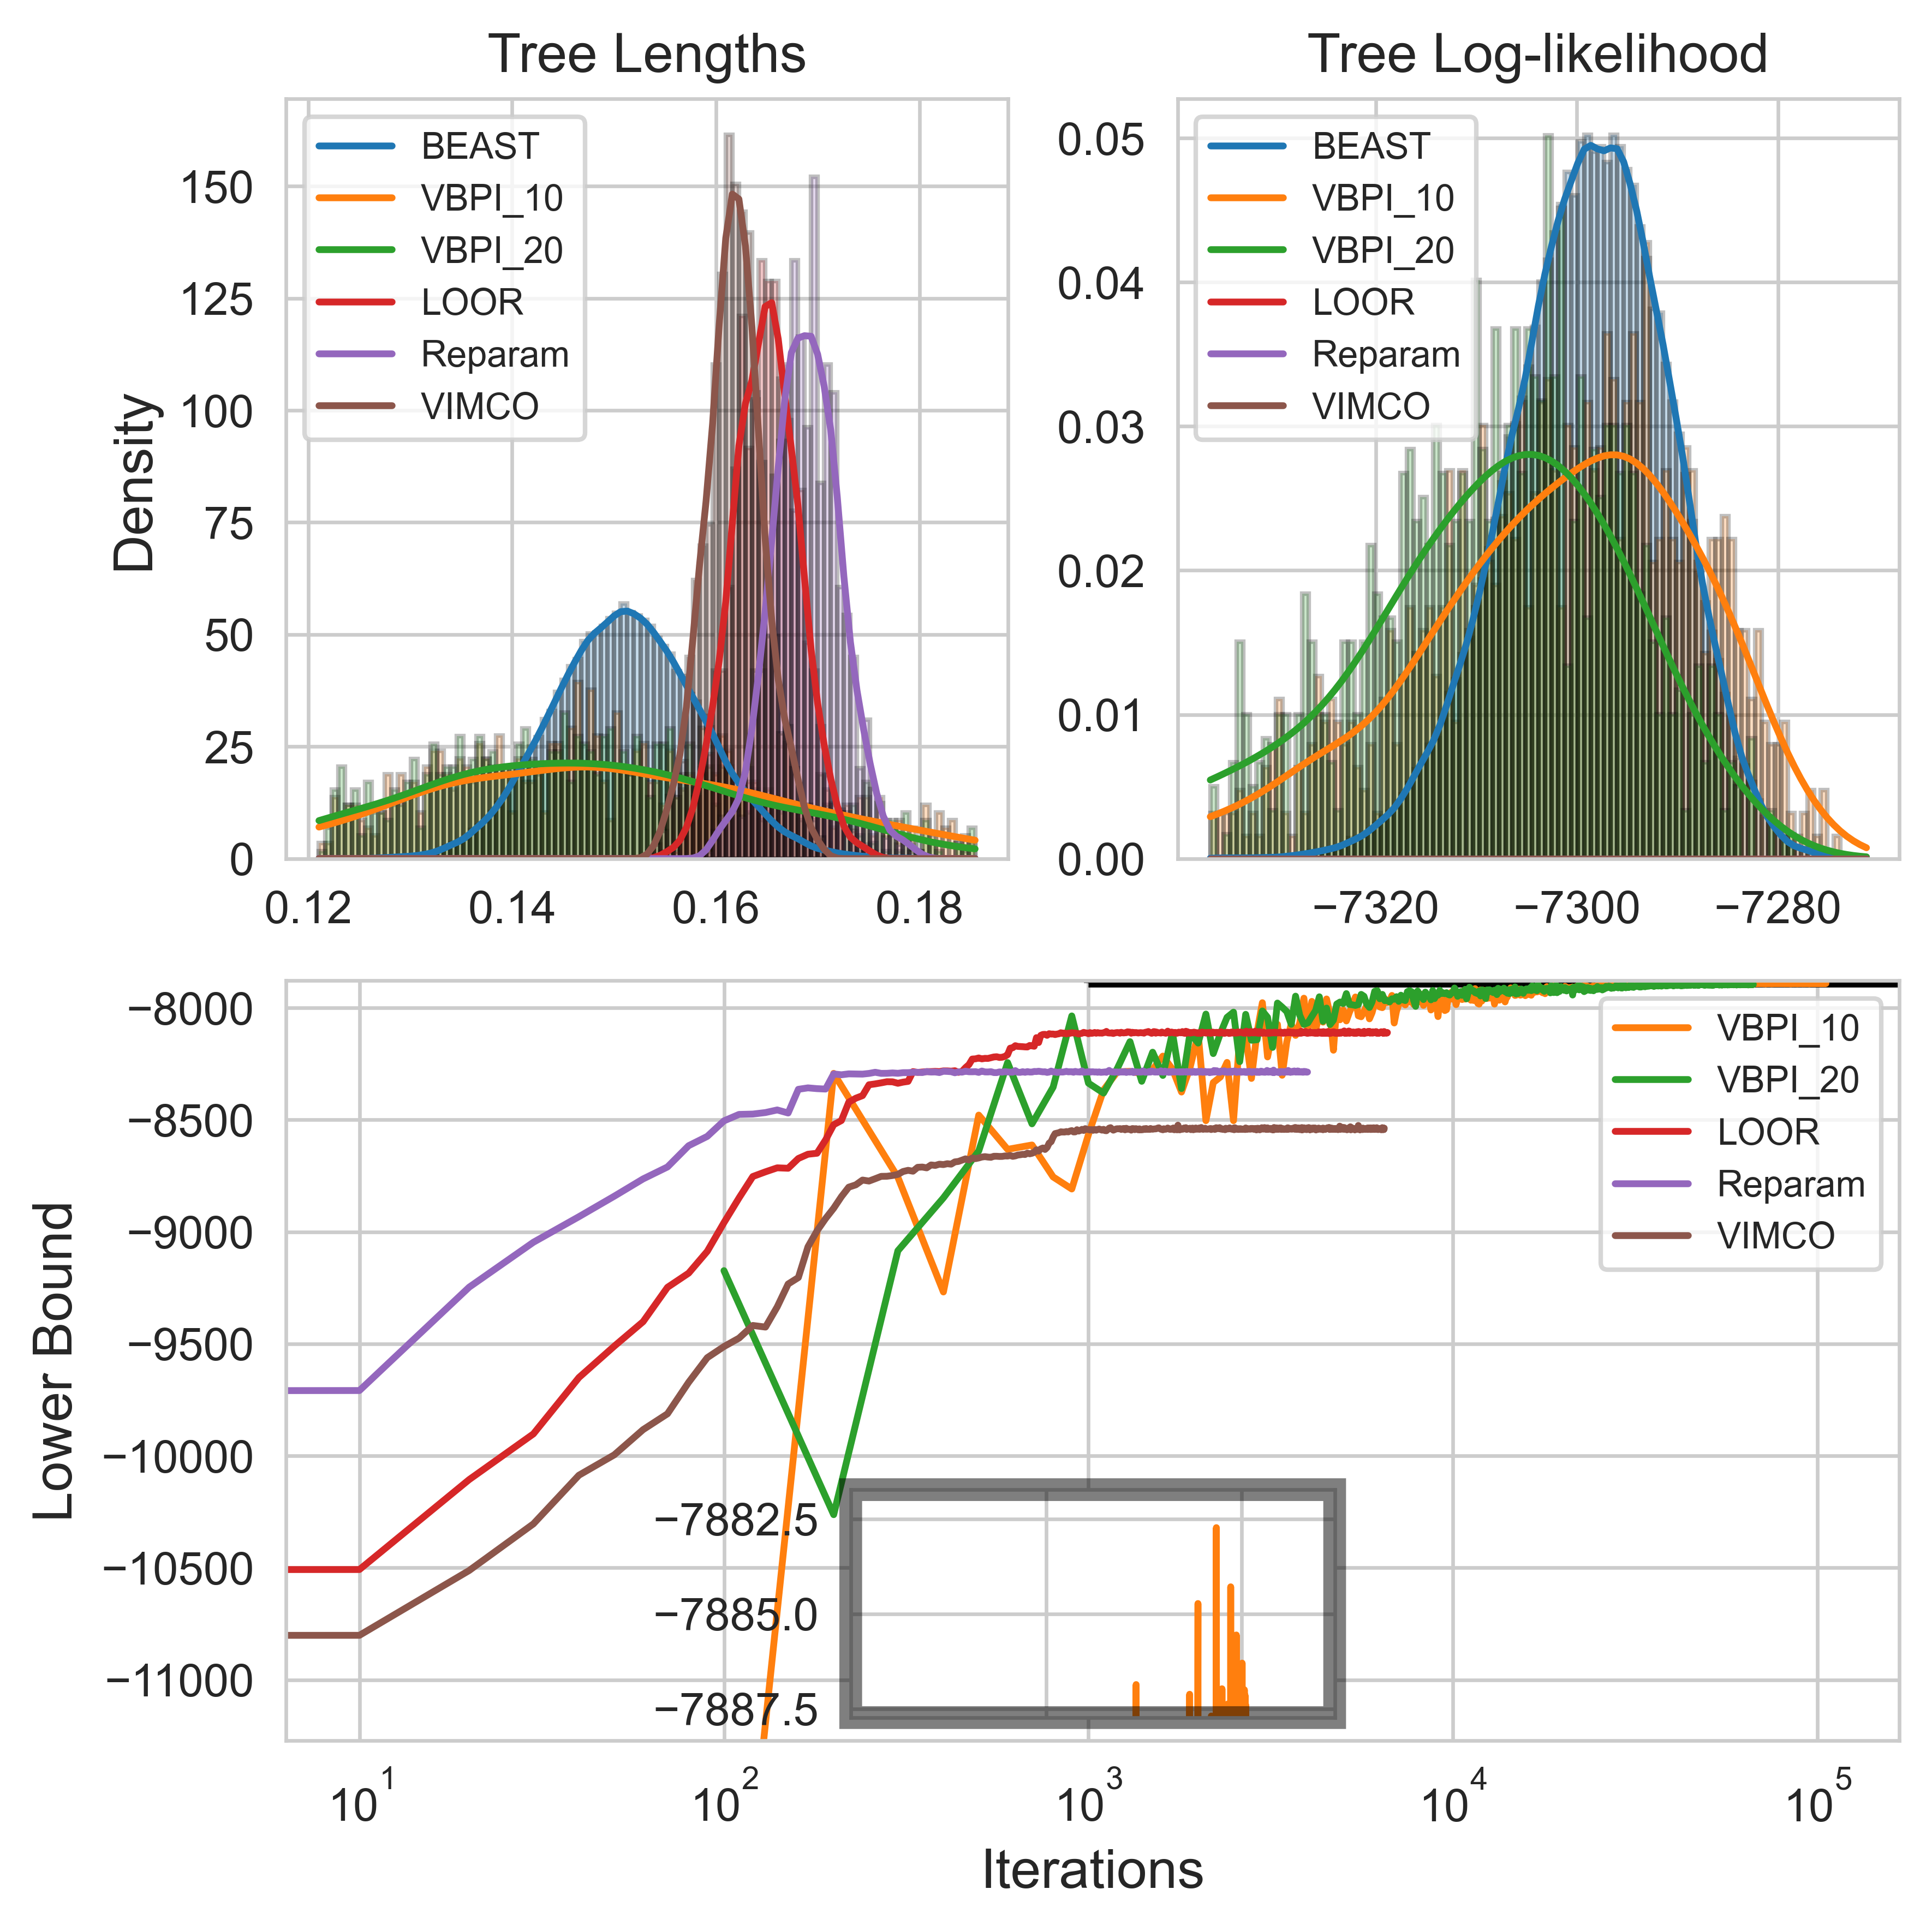

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=600, 
                         gridspec_kw={'height_ratios': [1, 1]})

colors = {"BEAST":plt.cm.tab10(0),
          "VBPI_10":plt.cm.tab10(1),
          "VBPI_20":plt.cm.tab10(2),
          "reinforce":plt.cm.tab10(3),
          "reparam":plt.cm.tab10(4),
          "VIMCO":plt.cm.tab10(5)}

keys = list(["BEAST","VBPI_10","VBPI_20","reinforce","reparam","VIMCO"])

### ELBO over time ###

plt.subplot(2,1,2)

plt.plot(VBPI_iters["10"],
         VBPI_lbs["10"],
         color = colors["VBPI_10"])

plt.plot(VBPI_iters["20"],
         VBPI_lbs["20"],
         color = colors["VBPI_20"])

plt.plot(optims["reinforce"].epochs,
         optims["reinforce"].multi_ELBO_ests,
         color = colors["reinforce"])

plt.plot(optims["reparam"].epochs,
         optims["reparam"].multi_ELBO_ests,
         color = colors["reparam"])

plt.plot(optims["VIMCO"].epochs,
         optims["VIMCO"].multi_ELBO_ests,
         color = colors["VIMCO"])

plt.xlabel("Iterations",fontsize = 12)
plt.ylabel("Lower Bound",fontsize = 12)

ELBO_max = max(max(VBPI_lbs["10"]),
               max(optims["reinforce"].multi_ELBO_ests),
               max(optims["reparam"].multi_ELBO_ests),
               max(optims["VIMCO"].multi_ELBO_ests))
ELBO_min = min(min(VBPI_lbs["10"]),
               min(optims["reinforce"].multi_ELBO_ests),
               min(optims["reparam"].multi_ELBO_ests),
               min(optims["VIMCO"].multi_ELBO_ests))

plt.ylim(min(min(optims["reinforce"].multi_ELBO_ests),
             max(VBPI_lbs["10"]))-5,
         ELBO_max+5)
plt.legend(["VBPI_10","VBPI_20","LOOR","Reparam","VIMCO"],prop={'size': 8})
plt.xscale('log')
zoom_region = (1000, 300000)  # Specify the region to zoom in
plt.gca().add_patch(plt.Rectangle((zoom_region[0], ELBO_max-5), zoom_region[1] - zoom_region[0], 6,
                                   edgecolor="black", facecolor="none", lw=2))

# Define the inset
axins = inset_axes(plt.gca(), width="30%", height="30%", loc="lower center")
axins.plot(VBPI_iters["10"],
           VBPI_lbs["10"],
           color = colors["VBPI_10"])

axins.plot(VBPI_iters["20"],
           VBPI_lbs["20"],
           color = colors["VBPI_20"])

axins.plot(optims["reinforce"].epochs,
           optims["reinforce"].multi_ELBO_ests,
           color = colors["reinforce"])

axins.plot(optims["reparam"].epochs,
         optims["reparam"].multi_ELBO_ests,
         color = colors["reparam"])

axins.plot(optims["VIMCO"].epochs,
         optims["VIMCO"].multi_ELBO_ests,
         color = colors["VIMCO"])

# Set inset limits and labels
axins.set_xlim(zoom_region)
axins.set_xscale('log')
axins.set_xticklabels([])
axins.set_ylim([ELBO_max-5,ELBO_max+1])


# Add a rectangle to indicate the zoomed region
plt.gca().indicate_inset_zoom(axins, edgecolor="black", lw=5)


### Tree lengths ###

plt.subplot(2,2,1)
data = {k: tree_lengths[k] for k in ["BEAST","VBPI_10","VBPI_20","reinforce","reparam","VIMCO"]}
title = "Tree Lengths"
i = 0

_, bins, _ = plt.hist(data[keys[0]], bins = 100, edgecolor='black', alpha = 0.25, 
                      density=True, color=colors[keys[0]])
density = gaussian_kde(data[keys[0]])
density_vals = density(bins)
plt.plot(bins, density_vals, linestyle='-', color=colors[keys[0]])

for key in keys[1:]:
    plt.hist(data[key], bins = bins, edgecolor='black', alpha = 0.25, 
             density=True, color=colors[key])
    density = gaussian_kde(data[key])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle='-', color=colors[key])

plt.legend(["BEAST","VBPI_10","VBPI_20","LOOR","Reparam","VIMCO"],prop={'size': 8})

plt.title(title)
plt.ylabel("Density",fontsize = 12)

### log-likelihooods ###

plt.subplot(2,2,2)
data = {k: log_likes[k] for k in ["BEAST","VBPI_10","VBPI_20","reinforce","reparam","VIMCO"]}
title = "Tree Log-likelihood"
i = 1

_, bins, _ = plt.hist(data[keys[0]], bins = 100, edgecolor='black', alpha = 0.25, 
                      density=True, color=colors[keys[0]])
density = gaussian_kde(data[keys[0]])
density_vals = density(bins)
plt.plot(bins, density_vals, linestyle='-', color=colors[keys[0]])

for key in keys[1:]:
    plt.hist(data[key], bins = bins, edgecolor='black', alpha = 0.25, 
             density=True, color=colors[key])
    density = gaussian_kde(data[key])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle='-', color=colors[key])

plt.legend(["BEAST","VBPI_10","VBPI_20","LOOR","Reparam","VIMCO"],prop={'size': 8})

plt.title(title)
#plt.ylabel("Density")

fig.delaxes(axes[1, 0])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.savefig('../../plt/'+data_set+'/'+data_set+'_hist.png')
plt.show()

In [25]:
# get bootstrap standard error of our models
def ELBO_se(p_qs):
    
    ELBO_hats = []
    
    for _ in range(1000):
        boot_sample = np.random.choice(p_qs,size=len(p_qs),replace=True)
        boot_ELBO = np.mean(boot_sample)
        ELBO_hats.append(boot_ELBO)
        
    return np.std(ELBO_hats,ddof=1)

def MLL_se(p_qs):
    
    MLL_hats = []
    
    for _ in range(1000):
        boot_sample = np.random.choice(p_qs,size=len(p_qs),replace=True)
        boot_MLL = logsumexp(boot_sample) - np.log(len(boot_sample))
        MLL_hats.append(boot_MLL)
        
    return np.std(MLL_hats,ddof=1)

(array([  1.,   0.,   0.,   0.,   3.,   6.,  10.,  68., 318., 594.]),
 array([-7217.83691406, -7211.17246094, -7204.50800781, -7197.84355469,
        -7191.17910156, -7184.51464844, -7177.85019531, -7171.18574219,
        -7164.52128906, -7157.85683594, -7151.19238281]),
 <BarContainer object of 10 artists>)

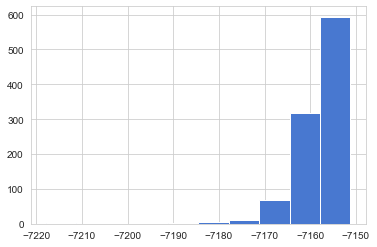

In [26]:
plt.hist(p_qs["VBPI_20"])

(array([  1.,   1.,   4.,   7.,   8.,  35., 120., 280., 483.,  61.]),
 array([-7187.62451172, -7183.81396484, -7180.00341797, -7176.19287109,
        -7172.38232422, -7168.57177734, -7164.76123047, -7160.95068359,
        -7157.14013672, -7153.32958984, -7149.51904297]),
 <BarContainer object of 10 artists>)

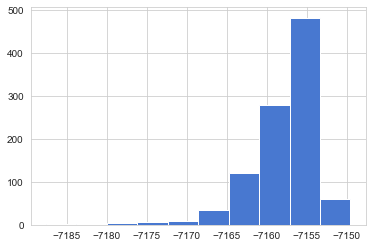

In [27]:
plt.hist(p_qs["VBPI_10"])

MLLs:

BEAST: -7154.264191973636 (0.19256495046313044)
VBPI_10: -0.26090228776592994 (0.15996315409016393)
VBPI_20: -0.45491544140622864 (0.08269990513764418)
reinforce: -2.417758442577906 (0.16372913805352984)
reparam: -2.364284660440717 (0.19597512426908095)
VIMCO: -0.921459964359201 (0.4346092279944298)

ELBO:

VBPI_10: -7157.714540527344 (0.12734045708297628)
VBPI_20: -7158.157648925781 (0.16041676181671446)
reinforce: -7159.5407714669045 (0.09825580745476852)
reparam: -7159.340446849562 (0.085874793404489)
VIMCO: -7161.5687297937375 (0.19778219101320238)


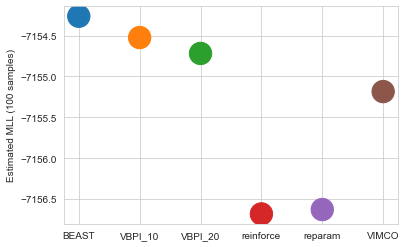

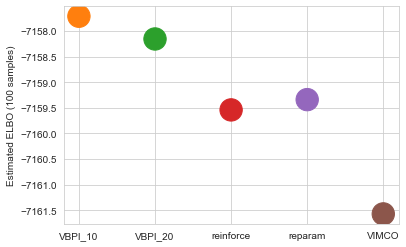

In [28]:
data = {'model': ["BEAST"] + [key for key in p_qs], 
        'MLL': [np.mean(BEAST_MLLs)] + [logsumexp(p_qs[key]) - np.log(len(p_qs[key])) for key in p_qs],
        'MLL_se': [np.std(BEAST_MLLs,ddof=1)] + [MLL_se(p_qs[key]) for key in p_qs],
        'ELBO': [np.nan] + [np.mean(p_qs[key]) for key in p_qs],
        'ELBO_se': [np.nan] + [ELBO_se(p_qs[key]) for key in p_qs]}
df = pd.DataFrame(data)

print("MLLs:")
print("")
print("BEAST: %s (%s)"%(data['MLL'][0],data['MLL_se'][0]))
for i,key in enumerate(p_qs):
    print("%s: %s (%s)"%(key,data['MLL'][i+1]-data['MLL'][0],data['MLL_se'][i+1]))

print("")
print("ELBO:")
print("")
for i,key in enumerate(p_qs):
    print("%s: %s (%s)"%(key,data['ELBO'][i+1],data['ELBO_se'][i+1]))


# Save the DataFrame to a CSV file
df.to_csv('../../plt/'+data_set+'/'+data_set+'_MLLs.csv', index=False)

plt.scatter(data["model"],data["MLL"],c=[colors[key] for key in colors],s=500)
plt.ylabel("Estimated MLL (100 samples)")
plt.savefig('../../plt/'+data_set+'/'+data_set+'_MLLs.png')
plt.show()

plt.scatter(data["model"],data["ELBO"],c=[colors[key] for key in colors],s=500)
plt.ylabel("Estimated ELBO (100 samples)")
plt.savefig('../../plt/'+data_set+'/'+data_set+'_ELBOs.png')

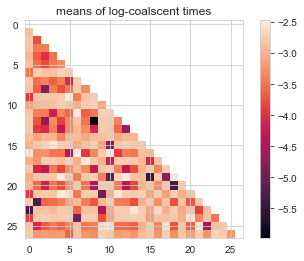

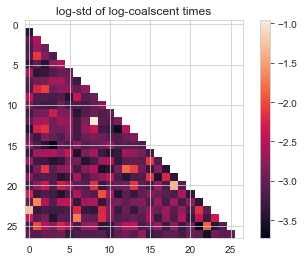

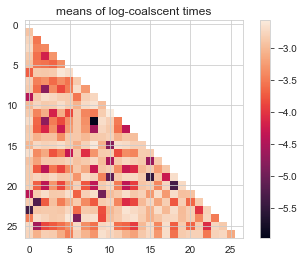

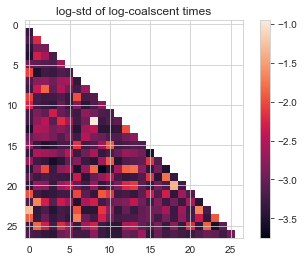

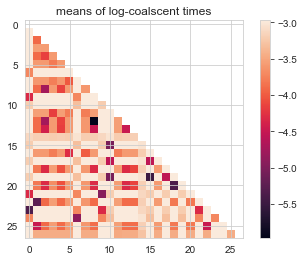

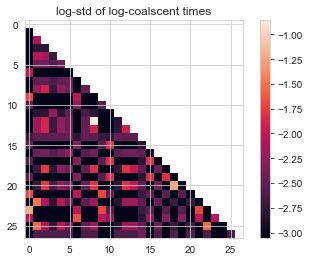

In [29]:
for theta in [optims["reparam"].theta,
              optims["reinforce"].theta,
              optims["VIMCO"].theta]:
    
    m = deepcopy(theta[0].detach())
    m[np.triu_indices(m.shape[0])] = np.nan
    plt.imshow(m)
    plt.title("means of log-coalscent times")
    plt.colorbar()
    plt.show()

    log_sig = deepcopy(theta[1].detach())
    log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
    plt.imshow(log_sig)
    plt.title("log-std of log-coalscent times")
    plt.colorbar()
    plt.show()